## Week 8 Report

### Key Tasks:

Filter Dataset to be only containing straight lines\
Create the sub-dataset\
Start modeling prediction containing geometry information

In [11]:
import os
import shutil
import json
import time
import argparse
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
import glob
import pickle

import networkx as nx

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import itertools

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras.models import Model, Sequential,model_from_json, load_model
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, LSTM, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from model_gcn import GCN

2.4.0
2.3.0


IndexError: list index out of range

### Data Filtering

The criteria for filtering the data is trivial. We will only preserve the designs that are composed of straight lines, and use those data for prediction.

In [12]:
# Hyperparametr: Predict the next words based on the immediate 
# last train_length number of words seen

class DatasetFilter:
    '''Class that filters Fusion 360 Dataset files'''
    def __init__(self, fileDir:str):

        with open(fileDir) as f:
            self.originaldata = json.load(f)
            self.entities = self.originaldata['entities']
            # Construct Dataframe for Debugging
            self.df = pd.DataFrame(data = self.originaldata['sequence']).drop(['smt','step','obj'], axis = 1)
            self.df['entities']=self.df['entity'].apply(lambda x: (self.originaldata['entities'])[x])
            self.df['curveBoolean'] = self.df.apply(self.curve_boolean, axis = 1)
            self.curveBoolean = self.df['curveBoolean'].sum()
    
    def extract_content(self, row):
        if row['type'] == 'Sketch':
            return (self.originaldata['entities'][row['entity']])['curves'][row['curve']]['type']
        else:
            return self.originaldata['entities'][row['entity']]

    def curve_boolean(self, row) -> int:
        flag = 0
        if (self.originaldata['entities'][row['entity']])['type'] == 'Sketch':
            curve = (self.originaldata['entities'][row['entity']])['curves'][row['curve']]
            sketchtype=curve['type']
            if sketchtype !='SketchLine':
                flag+=1
        return flag

In [58]:
sourceDir = "../../r1.0.0/"
targetDir = "../../straight/"

dataset_path = sourceDir+"reconstruction/"

with open(train_test) as f:
    train_test_split = json.load(f)

train_dir = train_test_split['train']
test_dir = train_test_split['test']

filtered_train = filtered_test = []

def filter_dataset(dataset_dir:str):
    filtered_index =[]
    for filename in dataset_dir:
        filedir = "reconstruction/"+filename
        example_data = DatasetFilter(sourceDir+filedir+'.json')
        if example_data.curveBoolean == 0:
            filtered_index.append(filename)
            try:
                shutil.copy(sourceDir+filedir+'.json', targetDir+filedir+'.json')
                shutil.copy(sourceDir+filedir+'.obj', targetDir+filedir+'.obj')
                shutil.copy(sourceDir+filedir+'.png', targetDir+filedir+'.png')
            except FileNotFoundError:
                os.mkdir(targetDir+"reconstruction/")

    return filtered_index

filtered_train = filter_dataset(train_dir)
filtered_test = filter_dataset(test_dir)

In [59]:
print(f'Number of Training Data After Filtering:{len(filtered_train)}')
print(f'Number of TesT Data After Filtering:{len(filtered_test)}')

Number of Training Data After Filtering:1298
Number of TesT Data After Filtering:317


### Plotting the filtered dataset

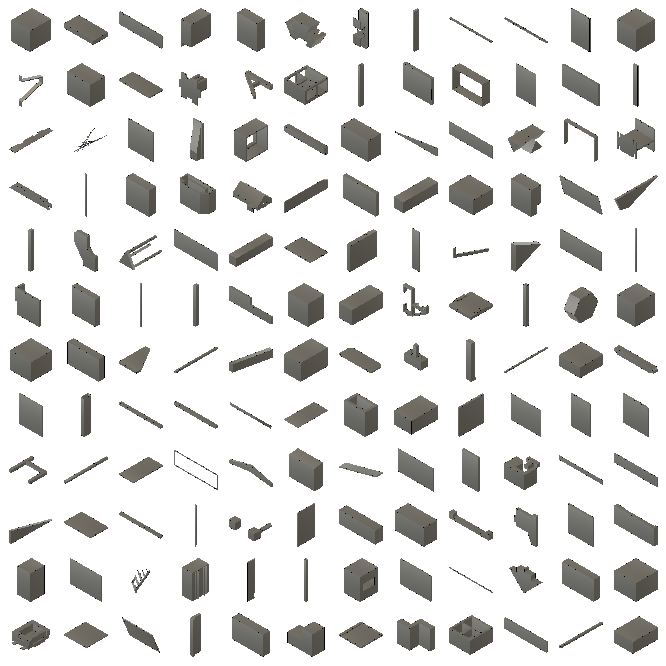

In [79]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg


images = []
for obj in filtered_train:
    images.append('C:/Users/Archolic/Desktop/Thesis/Dataset/Gallery360/straight/reconstruction/'+obj+'.png')

fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(12, 12),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, PATH in zip(grid, images[:150]):
    im = mpimg.imread(PATH)
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')

plt.show()


## Modify UV-Net for Modeling Command Prediction

Originally based on https://github.com/AutodeskAILab/Fusion360GalleryDataset/tree/master/tools/regraphnet

Instead of predicting the reconstruction commands of objects, this project propose to perform neural command prediction. The same UV-Net network structure is applied, yet for the reconstruction task, our only input would be the current geometry.

In [13]:
class NodePointer(nn.Module):
    def __init__(self,nfeat,nhid,dropout=0.0,Use_GCN=True):
        super(NodePointer,self).__init__()
        self.Use_GCN=Use_GCN
        self.nhid=nhid
        if Use_GCN:
            self.fc00=nn.Linear(nfeat,nhid)
            self.fc01=nn.Linear(nhid,nhid)
            self.fc10=nn.Linear(nfeat,nhid)
            self.fc11=nn.Linear(nhid,nhid)
            self.fc20=nn.Linear(nfeat*2,nhid)
            self.fc21=nn.Linear(nhid,nhid)
            self.gcn0=GCN(nfeat=nhid,nhid=nhid,dropout=dropout)
            self.gcn1=GCN(nfeat=nhid,nhid=nhid,dropout=dropout)
            self.gcn2=GCN(nfeat=nhid,nhid=nhid,dropout=dropout)
            self.fc02=nn.Linear(nhid,nhid)
            self.fc03=nn.Linear(nhid,nhid)
            self.fc12=nn.Linear(nhid,nhid)
            self.fc13=nn.Linear(nhid,nhid)
            self.fc22=nn.Linear(nhid,nhid)
            self.fc23=nn.Linear(nhid,nhid)
        else:
            self.fc00=nn.Linear(nfeat,nhid)
            self.fc01=nn.Linear(nhid,nhid)
            self.fc10=nn.Linear(nfeat,nhid)
            self.fc11=nn.Linear(nhid,nhid)
            self.fc20=nn.Linear(nfeat*2,nhid)
            self.fc21=nn.Linear(nhid,nhid)
        self.fc_operation=nn.Linear(nhid,5)
        self.fc0=nn.Linear(nhid*2,nhid*2)
        self.fc1=nn.Linear(nhid*2,nhid*2)
        self.fc2=nn.Linear(nhid*2,nhid*2)
        self.fc3=nn.Linear(nhid*2,nhid*2)
        self.fc_start=nn.Linear(nhid*2,1)
        self.fc4=nn.Linear(nhid,nhid)
        self.fc5=nn.Linear(nhid,nhid)
        self.fc6=nn.Linear(nhid,nhid)
        self.fc7=nn.Linear(nhid,nhid)
        self.fc_end=nn.Linear(nhid,1)
        for m in self.modules():
            if isinstance(m,nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.00)

    def forward(self,gpf,use_gpu=True):
        x2=torch.cat((gpf[1],gpf[1][gpf[4],:].repeat(gpf[1].size()[0],1)),dim=1)
        if self.Use_GCN:
            x0=F.relu(self.fc01(F.relu(self.fc00(gpf[1]))))
            x0=self.gcn0(x0,gpf[0])
            x0=F.relu(self.fc03(F.relu(self.fc02(x0))))
            x2=F.relu(self.fc21(F.relu(self.fc20(x2))))
            x2=self.gcn2(x2,gpf[0])
            x2=F.relu(self.fc23(F.relu(self.fc22(x2))))
            if gpf[2].size()[0]==0:
                if use_gpu:
                    x1=torch.zeros((1,self.nhid)).cuda()
                else:
                    x1=torch.zeros((1,self.nhid))
            else:
                x1=F.relu(self.fc11(F.relu(self.fc10(gpf[3]))))
                x1=self.gcn1(x1,gpf[2])
                x1=F.relu(self.fc13(F.relu(self.fc12(x1))))
        else:
            x0=F.relu(self.fc01(F.relu(self.fc00(gpf[1]))))
            x2=F.relu(self.fc21(F.relu(self.fc20(x2))))
            if gpf[2].size()[0]==0:
                if use_gpu:
                    x1=torch.zeros((1,self.nhid)).cuda()
                else:
                    x1=torch.zeros((1,self.nhid))
            else:
                x1=F.relu(self.fc11(F.relu(self.fc10(gpf[3]))))
        x1=torch.sum(x1,dim=0,keepdim=True).repeat(x0.size()[0],1)
        op=self.fc_operation(x1[0:1,:])
        x=torch.cat((x0,x1),dim=1)
        x=F.relu(self.fc0(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x_start=self.fc_start(x)
        x2=F.relu(self.fc4(x2))
        x2=F.relu(self.fc5(x2))
        x2=F.relu(self.fc6(x2))
        x2=F.relu(self.fc7(x2))
        x_end=self.fc_end(x2)
        return x_start,x_end,op

## Next Step: Create Training Dataset 

To create a training dataset, we batch convert the exisiting filtered BREPS into graph representation that could fit into the tensors of a GCN layer.